# Exploring Goodreads data


## 1. Setting up the environment
Importing all the required packages. A couple of notes:
- langdetect: helps detect language in any unicode string. We can use this to detect the language of the book
- cufflinks: cufflinks makes plotting with Pandas and Plotly a lot easier. 

In [1]:
!pip install langdetect -q
from langdetect import detect

import string
valid_chars=string.ascii_letters+string.digits+' '

import pandas as pd
import numpy as np

import cufflinks as cf
cf.go_offline()
from collections import defaultdict

from google.colab import files

def configure_plotly_browser_state():
    #This function is required to see Plotly charts in colab. Call this function in every cell where a Plotly chart gets drawn.
    import IPython
    display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.43.1.min.js?noext',
            },
          });
        </script>
        '''))

     |████████████████████████████████| 981 kB 5.3 MB/s 


## 2. Uploading Data


In [9]:
book_data_train=pd.read_csv('best-books-ever_data.csv')
book_data_test=pd.read_csv('best-books-of-2018_data.csv')

In [10]:
book_data_train.head()

book_authors  \
0                                    Suzanne Collins   
1                         J.K. Rowling|Mary GrandPré   
2                                         Harper Lee   
3  Jane Austen|Anna Quindlen|Mrs. Oliphant|George...   
4                                    Stephenie Meyer   

                                           book_desc  \
0  Winning will make you famous. Losing means cer...   
1  There is a door at the end of a silent corrido...   
2  The unforgettable novel of a childhood in a sl...   
3  «È cosa ormai risaputa che a uno scapolo in po...   
4  About three things I was absolutely positive.F...   

                         book_edition book_format    book_isbn book_pages  \
0                                 NaN   Hardcover  9.78044E+12  374 pages   
1                          US Edition   Paperback  9.78044E+12  870 pages   
2                    50th Anniversary   Paperback  9.78006E+12  324 pages   
3  Modern Library Classics, USA / CAN   Paperback  9.78068E+12  279 pages   
4                                 NaN   Paperback  9.78032E+12  498 pages   

   book_rating  book_rating_count  book_review_count  \
0         4.33            5519135             160706   
1         4.48            2041594              33264   
2         4.27            3745197              79450   
3         4.25            2453620              54322   
4         3.58            4281268              97991   

                                  book_title  \
0                           The Hunger Games   
1  Harry Potter and the Order of the Phoenix   
2                      To Kill a Mockingbird   
3                        Pride and Prejudice   
4                                   Twilight   

                                              genres  \
0  Young Adult|Fiction|Science Fiction|Dystopia|F...   
1                        Fantasy|Young Adult|Fiction   
2  Classics|Fiction|Historical|Historical Fiction...   
3                           Classics|Fiction|Romance   
4  Young Adult|Fantasy|Romance|Paranormal|Vampire...   

                                           image_url  
0  https://images.gr-assets.com/books/1447303603l...  
1  https://images.gr-assets.com/books/1255614970l...  
2  https://images.gr-assets.com/books/1361975680l...  
3  https://images.gr-assets.com/books/1320399351l...  
4  https://images.gr-assets.com/books/1361039443l...

## 3. Exploring genres
Let's explore the genres of the books. The genres on the goodreads website are tagged by the users, so it helps to keep in mind that the data may not be completely accurate.

There are multiple genres that a book can belong to, e.g., a detective novel can belong to fiction, mystery, thriller, etc. Let's see how to plot the number of genres as a histogram to see the distribution.

In [11]:
configure_plotly_browser_state()

def genre_count(genres):
    '''
    Returns the number of genres in the genre column of the dataframe
    Input: genre data
    Output: no. of genres
    '''
    try:
        return len(genres.split('|'))
    except:
        return 0


book_data_train['num_genres'] = book_data_train['genres'].apply(genre_count)
book_data_train['num_genres'].iplot(kind='histogram', xTitle='No. of genres', yTitle='Count', gridcolor='rgba(0,0,0,0)')

On average, we could see that books are tagged with around 5-6 genres. Let us now see how many unique genres are available and the counts.

In [12]:
genre_counts=defaultdict(int)
for i in book_data_train.index:
    g=book_data_train.at[i, 'genres']
    if type(g)==str:
        for j in g.split('|'):
            genre_counts[j]+=1

print(len(genre_counts))

866


There's a whopping 866 unique genres in the data collected! While it may not be worth looking at each and every genre, let's take a look at the top genres.

In [13]:
configure_plotly_browser_state()
genre_counts_df=pd.DataFrame.from_records(sorted(genre_counts.items(), key=lambda x:x[1], reverse=True), columns=['genre', 'count'])
genre_counts_df[:50].iplot(
    kind='bar', 
    x='genre', 
    y='count',
    margin={
        'b':175
    },
    gridcolor='rgba(0,0,0,0)'
)

There seems to be quite a long tail of genres even in the top 50 list. Interestingly, the number of nonfiction books is quite low compared to fiction

## 4. Exploring book covers
Let us take a look at some of the book covers that we have collected to see if there are any discernible patterns mapping them to their respective genres.

In [ ]:
#In google colab first upload the zip file of the image and then unzip it using below command
!unzip /train_images.zip

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
from os.path import exists

def plot_book_covers(n):
    '''
    Prints a specified no. of book covers and their corresponding genres. Helps to examine if there is any pattern in the book covers
    Input: no. of book covers to display
    Output: None
    '''
    indices=list(np.random.randint(min(book_data_train.index), max(book_data_train.index), size=n))
    fig=plt.figure(figsize=(n*5, 10))
    for i in indices:
        if exists(f'train/images/{i}.jpg'):
            ax = fig.add_subplot(2, n, (indices.index(i)+1), xticks=[], yticks=[])
            ax.imshow(Image.open(f'train/images/{i}.jpg'))
            ax = fig.add_subplot(2, n, (indices.index(i)+1)+n, xticks=[], yticks=[])
            if type(book_data_train.at[i, 'genres'])==str:
                t='\n'.join(book_data_train.at[i, 'genres'].split('|'))
            else:
                t=''
            ax.text(0.5, 0.5, t, fontsize=15, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

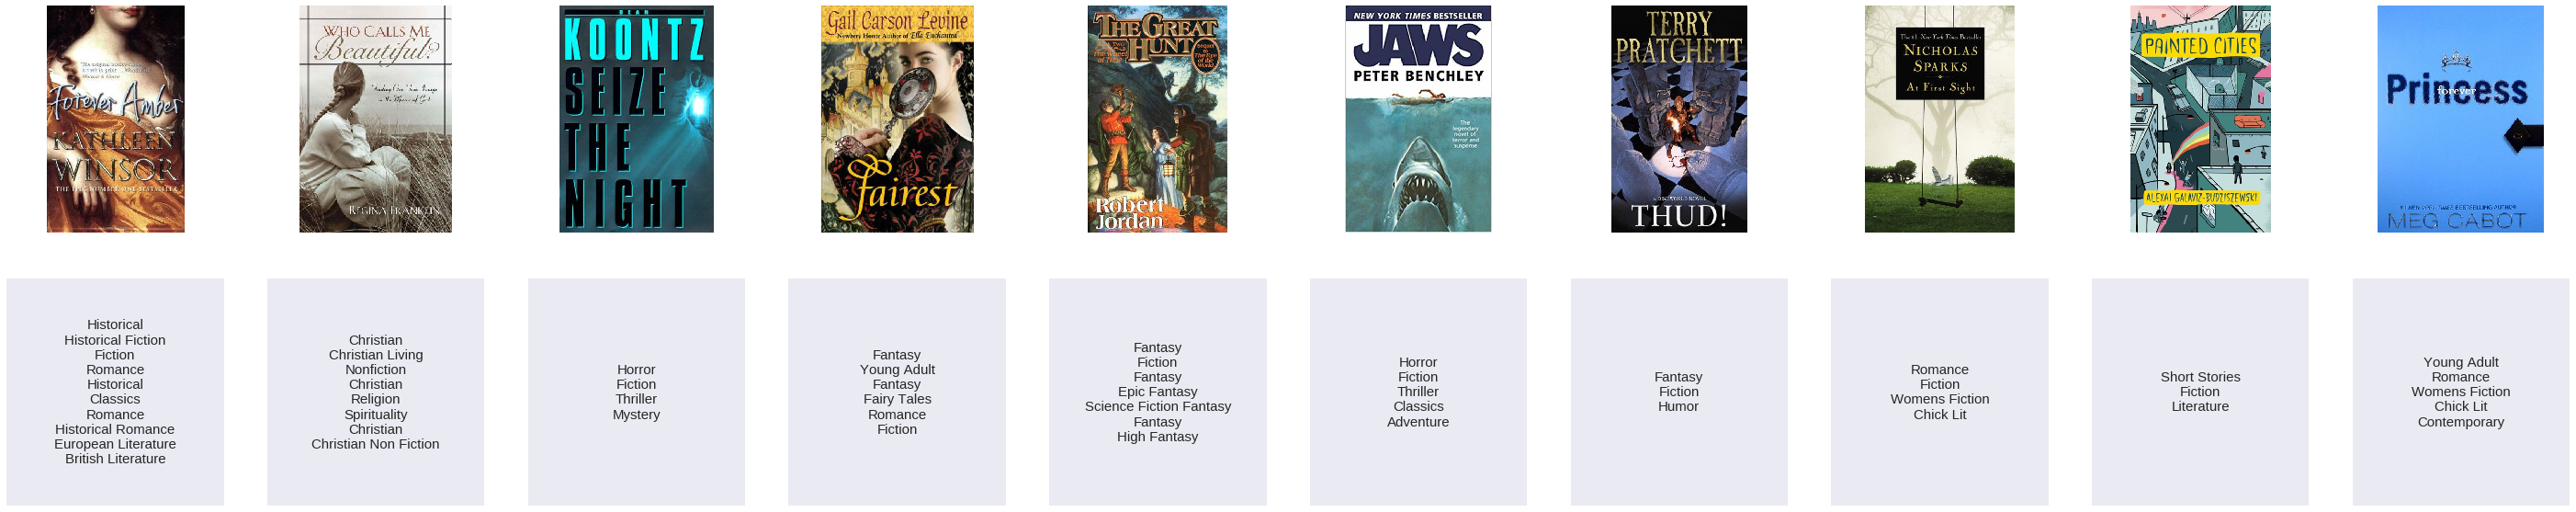

In [ ]:
plot_book_covers(10)

From a first glance, I am not able to see any specific patterns in general between the book covers and the corresponding genres. Some of them seem to have random photos that don't have anything to do with the book title or genres. Let us explore other attributes of the dataset.

## 5. Exploring authors
Some of the books seem to have multiple authors. Similar to genres, let us take a look at the number of authors for each book.

In [ ]:
book_data_train['num_authors']=book_data_train['book_authors'].str.split('|').apply(len)
configure_plotly_browser_state()
book_data_train['num_authors'].iplot(kind='histogram', xTitle='No. of authors', yTitle='Count', gridcolor='rgba(0,0,0,0)')

Wow! While a majority of the books seem to have just one author, we do seem to have some that have more than 10 authors (even 50, in some cases). Let us take a look at these books to make sure the data is not invalid.

In [ ]:
book_data_train[book_data_train['num_authors']>10].head()

book_authors  \
513   P.D. Eastman|Merwin Goldsmith|MARIAN HAILEY|Ro...   
2078  Neil Gaiman|Mike Dringenberg|Chris Bachalo|Mic...   
3207  Plato|Benjamin Jowett|John M. Cooper|Dorothea ...   
3322  Neil Gaiman|Marc Hempel|Richard Case|D'Israeli...   
3475  Neil Gaiman|Jill Thompson|Vince Locke|Bryan Ta...   

                                              book_desc book_edition  \
513   ARE YOU MY MOTHER? tells a very simple story f...          NaN   
2078  One of the most popular and critically acclaim...          NaN   
3207  Outstanding translations by leading contempora...          NaN   
3322  The Penultimate volume to the phenomenal Sandm...          NaN   
3475  One of the most popular and critically acclaim...          NaN   

              book_format    book_isbn  book_pages  book_rating  \
513             Paperback     9.78E+12    64 pages         4.17   
2078  Slipcased Hardcover   9.7814E+12   612 pages         4.65   
3207            Hardcover  9.78087E+12  1808 pages         4.34   
3322            Hardcover  9.78156E+12   352 pages         4.59   
3475  Slipcased Hardcover   9.7814E+12   616 pages         4.70   

      book_rating_count  book_review_count  \
513              192438               2129   
2078              14832                512   
3207               9035                127   
3322              38524               1035   
3475               6146                128   

                              book_title  \
513                   Are You My Mother?   
2078    The Absolute Sandman, Volume One   
3207                      Complete Works   
3322                     The Kindly Ones   
3475  The Absolute Sandman, Volume Three   

                                                 genres  \
513                   Childrens|Childrens|Picture Books   
2078  Sequential Art|Graphic Novels|Sequential Art|C...   
3207                     Philosophy|Classics|Nonfiction   
3322  Sequential Art|Graphic Novels|Sequential Art|C...   
3475  Sequential Art|Comics|Sequential Art|Graphic N...   

                                              image_url  num_genres  \
513   https://images.gr-assets.com/books/1389098758l...           3   
2078  https://images.gr-assets.com/books/1312226853l...           6   
3207  https://images.gr-assets.com/books/1415678006l...           3   
3322  https://images.gr-assets.com/books/1339922887l...           7   
3475  https://images.gr-assets.com/books/1308879310l...           6   

      num_authors  
513            11  
2078           15  
3207           35  
3322           11  
3475           21

Upon researching these books, it seems that most of them are either illustrated books for children or collections of short stories. In the case of illustrated books, there are multiple illustrators, each of whom is listed as an author. And in the case of collections of short stories, the author of each short story is also listed as the author.

## 6. Exploring languages
One of the first things I noticed in the dataset was that there are books of various languages available in the list. If we need to run an experiment on the text of the book's description, we will need to make sure that they are all from the same language.

Let us look at the various languages available in the dataset.

In [ ]:
def remove_invalid(df):
    '''
    Removes records that have invalid descriptions from the dataframe
    Input: dataframe
    Output: Cleaned up dataframe
    '''
    invalid_desc_idxs=[]
    for i in df.index:
        try:
            a=detect(df.at[i,'book_desc'])
        except:
            invalid_desc_idxs.append(i)
    
    df=df.drop(index=invalid_desc_idxs)
    return df

book_data_train=remove_invalid(book_data_train)
book_data_train['lang']=book_data_train.book_desc.apply(detect)

#Downloading the list of languages to map the two-letter lang code to the language name
lang_lookup=pd.read_html('https://en.wikipedia.org/wiki/List_of_ISO_639-1_codes')[1]
lang_lookup.drop(columns=[0], inplace=True)
lang_lookup.columns=lang_lookup.iloc[0]
lang_lookup=lang_lookup.reindex(lang_lookup.index.drop(0))
lang_lookup.rename(columns={'639-1': 'lang'}, inplace=True)

def get_language(lang):
    if lang in list(lang_lookup['lang']):
        return lang_lookup[lang_lookup['lang']==lang]['ISO language name'].values[0]
    else:
        return 'N/A'

book_data_train['language']=book_data_train['lang'].apply(get_language)

In [ ]:
configure_plotly_browser_state()
group_by_lang=book_data_train.groupby(['language'])['book_title'].count().reset_index().sort_values(by=['book_title'], ascending=False)
group_by_lang.iplot(
    kind='bar', 
    x='language', 
    y='book_title',
    margin={
        'b':200
    },
    gridcolor='rgba(0,0,0,0)'
)

It's really interesting to see such a diverse set of languages in the list of top books of all time. English constitutes almost 90% of the books, though. Let us remove English from the chart to see the distribution better.

In [ ]:
configure_plotly_browser_state()
group_by_lang[group_by_lang['language']!='English'].iplot(
    kind='bar', 
    x='language', 
    y='book_title',
    margin={
        'b':210
    },
    gridcolor='rgba(0,0,0,0)'
)